In [122]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

In [123]:
import tensorflow
tensorflow.__version__

'2.17.1'

In [124]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape,UpSampling2D,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [125]:
import numpy as np

data = np.load('/content/drive/MyDrive/Colab Notebooks/Face Recognition/Images.npy', allow_pickle=True)
print(data.shape)


(393, 2)


In [126]:
X=data[1,0]
X.shape
print(data.shape,X.shape)

(393, 2) (697, 1280, 4)


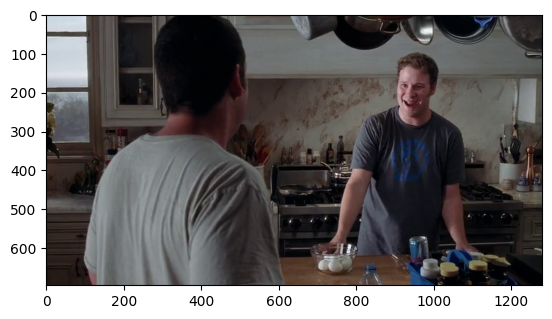

In [127]:
from matplotlib import pyplot as plt
plt.imshow(X)
plt.show()
from PIL import Image
im = Image.fromarray(data[0,0].astype(np.uint8))
im.show()

In [128]:
data[3]

array([array([[[250, 250, 250],
               [250, 250, 250],
               [250, 250, 250],
               ...,
               [190, 201, 107],
               [193, 204, 110],
               [193, 204, 108]],

              [[250, 250, 250],
               [250, 250, 250],
               [250, 250, 250],
               ...,
               [191, 203, 105],
               [192, 204, 106],
               [193, 205, 105]],

              [[250, 250, 250],
               [250, 250, 250],
               [250, 250, 250],
               ...,
               [187, 200,  94],
               [184, 197,  91],
               [185, 198,  90]],

              ...,

              [[191, 191, 203],
               [170, 170, 182],
               [167, 167, 177],
               ...,
               [ 24,  41,  71],
               [ 14,  33,  66],
               [  7,  27,  64]],

              [[190, 190, 202],
               [172, 172, 184],
               [170, 170, 182],
               ...,
        

### Set image dimensions
- Initialize image height, image width with value: 224

In [129]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [130]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [131]:
X_train.shape

(393, 224, 224, 3)

In [132]:
masks.shape

(393, 224, 224)

### Print a sample image and image array

[[[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.59215689  0.68627453 -0.08235294]
  [ 0.49019611  0.57647061 -0.17647058]
  [ 0.51372552  0.60784316 -0.13725489]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.65490198  0.74117649 -0.01960784]
  [ 0.54509807  0.63921571 -0.14509803]
  [ 0.47450984  0.56862748 -0.23921567]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.7647059   0.82745099  0.05098045]
  [ 0.58431375  0.67058825 -0.18431371]
  [ 0.34117651  0.45098042 -0.48235291]]

 ...

 [[ 0.34117651  0.34117651  0.41960788]
  [ 0.52941179  0.52941179  0.60784316]
  [ 0.28627455  0.28627455  0.34901965]
  ...
  [ 0.14509809 -0.10588235 -0.09803921]
  [-0.69411767 -0.62352943 -0.4588235 ]
  [-0.89019608 -0.74117649 -0.47450978]]

 [

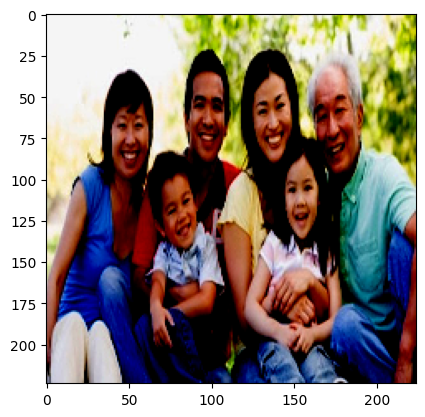

In [133]:
from matplotlib import pyplot
n = 3
print(X_train[n])
pyplot.imshow(X_train[n])

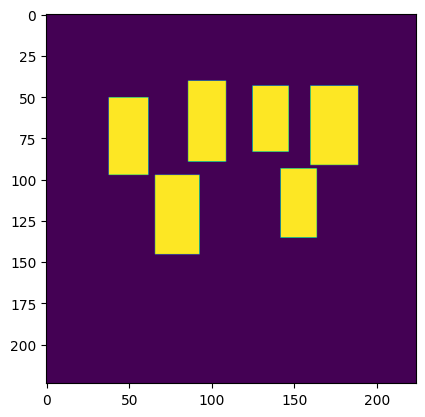

In [134]:
pyplot.imshow(masks[n]) # showing the mask for the image

## Create the model
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [135]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")

    block0 = model.get_layer("conv_pw_1_relu").output
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

In [136]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=False)

# Print summary
model.summary()

Model: "functional_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 112, 112, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 112, 112, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 112, 112, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 112, 112, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 112, 112, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 113, 113, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 56, 56, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 56, 56, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 56, 56, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn         

 Total params: 3,230,849 (12.32 MB)

 Trainable params: 3,208,961 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Define dice coefficient function
- Create a function to calculate dice coefficient


In [137]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)  # Use K.sum correctly
    dice = (2. * intersection + smooth) / (K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)
    return dice


### Define loss

In [138]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [139]:
model.compile(optimizer='adam', loss=loss, metrics= [(dice_coefficient)])

### Define checkpoint and earlystopping

In [140]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "model-{loss:.2f}.weights.h5",  # Use .weights.h5 extension
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq='epoch'  # Save after each epoch
)


stop = EarlyStopping(monitor="loss", patience=5, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.3,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode="min"
)


### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [141]:
model.fit(X_train,masks,
          epochs=10,
          batch_size=1,callbacks=[checkpoint, stop, reduce_lr])

Epoch 1/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coefficient: 0.6359 - loss: 1.4086
Epoch 1: loss improved from inf to 1.11855, saving model to model-1.12.weights.h5
393/393 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - dice_coefficient: 0.6360 - loss: 1.4078 - learning_rate: 0.0010
Epoch 2/10
392/393 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coefficient: 0.7551 - loss: 0.6960
Epoch 2: loss improved from 1.11855 to 0.73950, saving model to model-0.74.weights.h5
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - dice_coefficient: 0.7551 - loss: 0.6962 - learning_rate: 0.0010
Epoch 3/10
391/393 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dice_coefficient: 0.7851 - loss: 0.6126
Epoch 3: loss improved from 0.73950 to 0.60922, saving model to model-0.61.weights.h5
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - dice_coefficient: 0.7851 - loss: 0.6126 - learning_rate: 0.0010
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coefficient: 0.8199 - loss: 0.4877
Epoch 4: loss improved from 0.60922 to 

### Get the predicted mask for a sample image  

In [142]:
idx = 10
x=np.array(X_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [143]:
print(predict.shape, predict.min(), predict.max(), predict.mean())

(1, 224, 224) 2.2157445e-13 0.8841934 0.013504155


In [144]:
predict[0]

array([[2.6656571e-07, 2.6656571e-07, 2.1057726e-07, ..., 6.1130123e-10,
        9.9935671e-10, 9.9935671e-10],
       [2.6656571e-07, 2.6656571e-07, 2.1057726e-07, ..., 6.1130123e-10,
        9.9935671e-10, 9.9935671e-10],
       [2.4629986e-07, 2.4629986e-07, 2.9606679e-07, ..., 8.8588609e-10,
        6.9304790e-10, 6.9304790e-10],
       ...,
       [1.2951119e-10, 1.2951119e-10, 1.8554346e-10, ..., 6.1879283e-13,
        3.6553760e-13, 3.6553760e-13],
       [1.3445113e-10, 1.3445113e-10, 1.2706340e-10, ..., 3.9907642e-13,
        5.1413068e-13, 5.1413068e-13],
       [1.3445113e-10, 1.3445113e-10, 1.2706340e-10, ..., 3.9907642e-13,
        5.1413068e-13, 5.1413068e-13]], dtype=float32)

### Impose the mask on the image

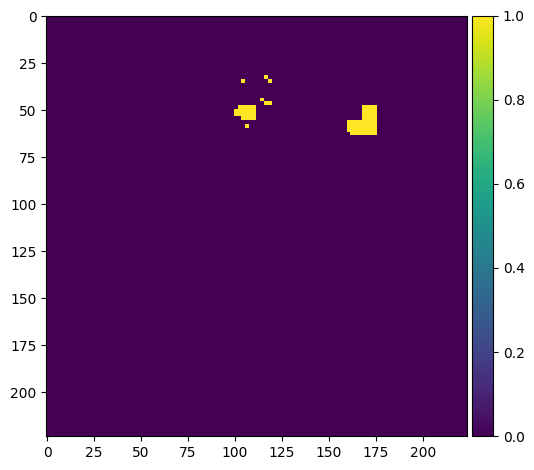

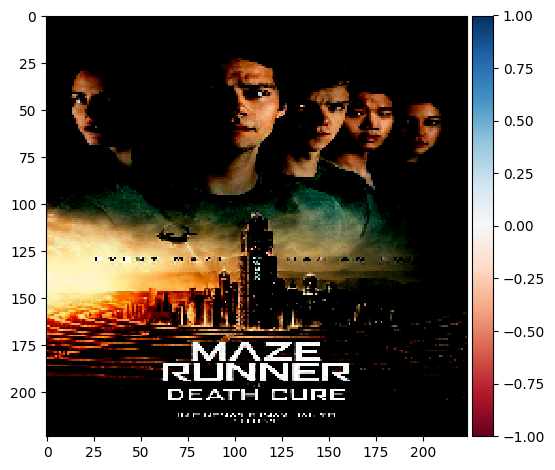

In [145]:
from skimage.io import imread, imshow


predict = (predict > 0.5).astype(np.uint8)
imshow(np.squeeze(predict[0]))
plt.show()

imshow(X_train[idx])

plt.show()

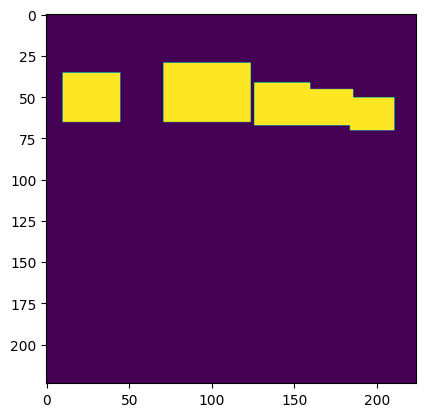

In [146]:
pyplot.imshow(masks[10]) # Original Mask for comparison

Overall quite accurate prediction for this image


## DOMAIN: Face recognition


#### **PROJECT  OBJECTIVE**: Face  Aligned  Face  Dataset  from  Pinterest.  This  dataset  contains  10,770  images  for  100  people.  All  images  are  taken from 'Pinterest' and aligned using dlib library. Some data samples:

In [147]:
# Imports

import tensorflow
tensorflow.__version__

'2.17.1'

In [148]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 2.2.2
Numpy version: 1.26.4
Scikit-learn version: 1.6.0
Tensorflow version: 2.17.1
CV version: 4.10.0


In [149]:
!ls

drive		       model-0.38.weights.h5  model-0.53.weights.h5  model-0.76.weights.h5
embeddings.pickle      model-0.43.weights.h5  model-0.55.weights.h5  model-1.10.weights.h5
model-0.29.weights.h5  model-0.45.weights.h5  model-0.60.weights.h5  model-1.11.weights.h5
model-0.32.weights.h5  model-0.49.weights.h5  model-0.61.weights.h5  model-1.12.weights.h5
model-0.33.weights.h5  model-0.51.weights.h5  model-0.63.weights.h5  PINS
model-0.37.weights.h5  model-0.52.weights.h5  model-0.74.weights.h5  sample_data


In [150]:
!file '/content/drive/MyDrive/Colab Notebooks/Face Recognition/PINS.zip'

/content/drive/MyDrive/Colab Notebooks/Face Recognition/PINS.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [151]:
with ZipFile('/content/drive/MyDrive/Colab Notebooks/Face Recognition/PINS.zip', 'r') as zip:
    print(zip.namelist())


['PINS/pins_Aaron Paul/', 'PINS/pins_Aaron Paul/Aaron Paul0_262.jpg', 'PINS/pins_Aaron Paul/Aaron Paul101_247.jpg', 'PINS/pins_Aaron Paul/Aaron Paul101_248.jpg', 'PINS/pins_Aaron Paul/Aaron Paul101_249.jpg', 'PINS/pins_Aaron Paul/Aaron Paul103_217.jpg', 'PINS/pins_Aaron Paul/Aaron Paul113_228.jpg', 'PINS/pins_Aaron Paul/Aaron Paul114_271.jpg', 'PINS/pins_Aaron Paul/Aaron Paul116_240.jpg', 'PINS/pins_Aaron Paul/Aaron Paul117_213.jpg', 'PINS/pins_Aaron Paul/Aaron Paul119_219.jpg', 'PINS/pins_Aaron Paul/Aaron Paul120_290.jpg', 'PINS/pins_Aaron Paul/Aaron Paul124_221.jpg', 'PINS/pins_Aaron Paul/Aaron Paul126_291.jpg', 'PINS/pins_Aaron Paul/Aaron Paul129_259.jpg', 'PINS/pins_Aaron Paul/Aaron Paul129_260.jpg', 'PINS/pins_Aaron Paul/Aaron Paul130_215.jpg', 'PINS/pins_Aaron Paul/Aaron Paul132_236.jpg', 'PINS/pins_Aaron Paul/Aaron Paul136_225.jpg', 'PINS/pins_Aaron Paul/Aaron Paul137_250.jpg', 'PINS/pins_Aaron Paul/Aaron Paul138_233.jpg', 'PINS/pins_Aaron Paul/Aaron Paul140_243.jpg', 'PINS/pins

In [152]:
pinterest_images = '/content/drive/MyDrive/Colab Notebooks/Face Recognition/PINS.zip'
import zipfile
archive = zipfile.ZipFile(pinterest_images, 'r')
archive.extractall()

Exception ignored in: <function ZipFile.__del__ at 0x7f499b26e8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
  File "/usr/lib/python3.10/zipfile.py", line 1856, in close
  File "/usr/lib/python3.10/zipfile.py", line 1956, in _fpclose
OSError: [Errno 107] Transport endpoint is not connected


### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id


In [153]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')
metadata

array([PINS/pins_Jeremy Renner/Jeremy Renner2.jpg,
       PINS/pins_Jeremy Renner/Jeremy Renner4.jpg,
       PINS/pins_Jeremy Renner/Jeremy Renner54.jpg, ...,
       PINS/pins_Jon Bernthal/Jon Bernthal62_2192.jpg,
       PINS/pins_Jon Bernthal/Jon Bernthal109_2183.jpg,
       PINS/pins_Jon Bernthal/Jon Bernthal172_2136.jpg], dtype=object)

### Define function to load image
- Define a function to load image from the metadata

In [154]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image

- Load one image using the function "load_image"

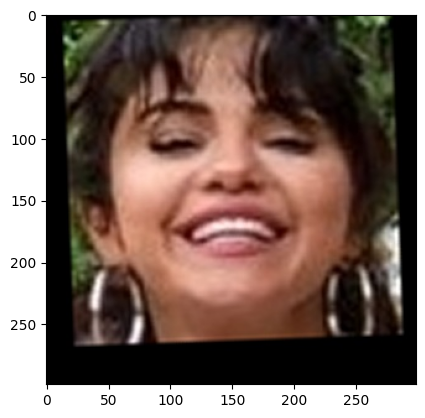

In [155]:
import matplotlib.pyplot as plt
plt.imshow(load_image(metadata[np.random.randint(0, 4382)].image_path()))

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [157]:
model = vgg_face()
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Face Recognition/vgg_face_weights.h5')
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ zero_padding2d_78 (ZeroPadding2D)    │ (None, 226, 226, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_79 (ZeroPadding2D)    │ (None, 226, 226, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_80 (ZeroPadding2D)    │ (None, 114, 114, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_81 (ZeroPadding2D)    │ (None, 114, 114, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_82 (ZeroPadding2D)    │ (None, 58, 58, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_83 (ZeroPadding2D)    │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_84 (ZeroPadding2D)    │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_85 (ZeroPadding2D)    │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_86 (ZeroPadding2D)    │ (None, 30, 30, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

### Get vgg_face_descriptor

In [158]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [159]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(2622,)


### Generate embeddings for all images
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [160]:
# Method to generate embeddings for all images
def generate_all_embeddings(metadata):
    # Create an embedding vector of all zeros, then fill it up with actual image embeddings iteratively.
    embeddings = np.zeros((metadata.shape[0], 2622))
    for idx, meta in enumerate(metadata):
        try:
            img = load_image(meta.image_path())
        # scale RGB values to interval [0,1]
            img = cv2.resize(img, dsize = (224,224))
            img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
            embeddings[idx] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
        except Exception as ex:
            print('Could not generate embedding s for', meta.image_path(), ' Exception--', str(ex))
    return embeddings

In [161]:
import pickle
embedding_pkl = 'embeddings.pickle'

# Generate all embeddings and serialize it in the drive
if os.path.isfile(embedding_pkl) and os.path.getsize(embedding_pkl) > 0:
    embeddings = pickle.load(open(embedding_pkl,"rb"))
else:
    embeddings = generate_all_embeddings(metadata)
    with open(embedding_pkl, 'wb') as handle:
        pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [162]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

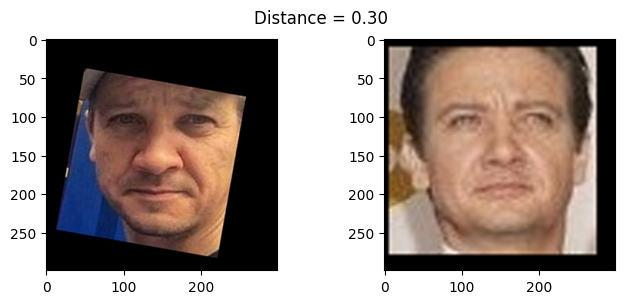

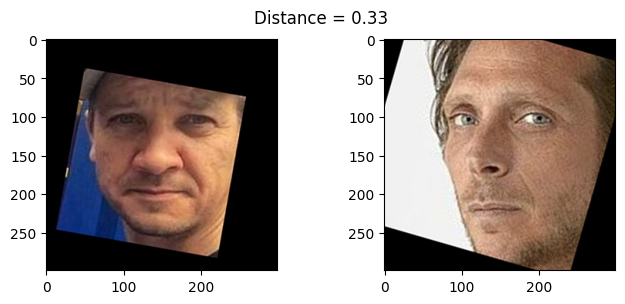

In [163]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

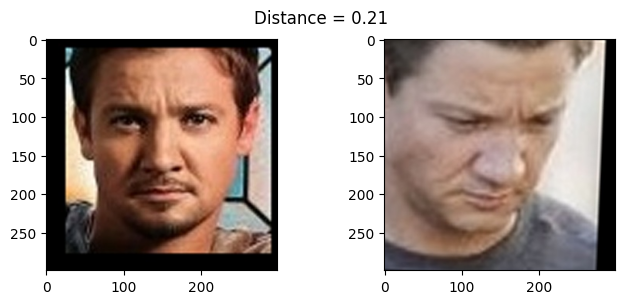

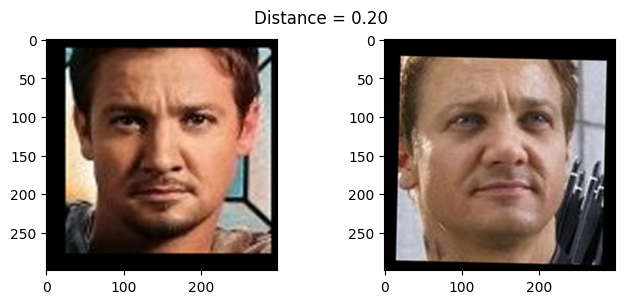

In [164]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(30, 31)
show_pair(30, 100)

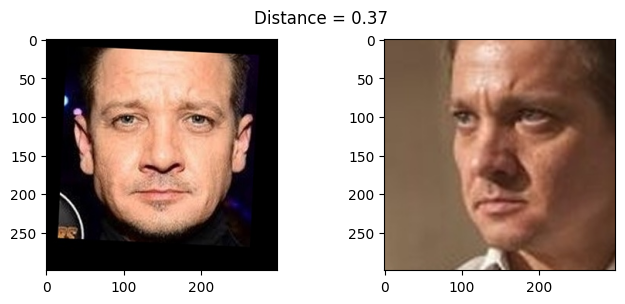

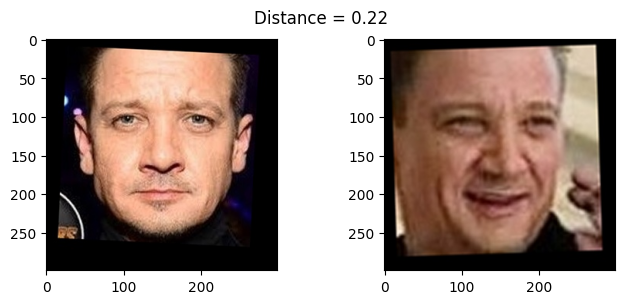

In [165]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [166]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

### Encode the Labels
- Encode the targets
- Use LabelEncoder

In [167]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Numerical encoding of identities
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Standardize the feature values
- Scale the features using StandardScaler

In [168]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Reduce dimensions using PCA
- Reduce feature dimensions using Principal Component Analysis

In [169]:
from sklearn.decomposition import PCA
# Create a covariance matrix and calculate eigen values
covar_mat = PCA().fit(X_train)
# calculate variance ratios
var = covar_mat.explained_variance_ratio_;var

array([1.35638508e-01, 5.37701230e-02, 3.99844531e-02, ...,
       1.69414923e-09, 1.62284760e-09, 9.25390814e-11])

In [170]:
# cumulative sum of variance explained with [n] features
eigen_vals = np.round(covar_mat.explained_variance_ratio_, decimals=3)*100
np.cumsum(eigen_vals)

array([13.6, 19. , 23. , ..., 91.8, 91.8, 91.8])

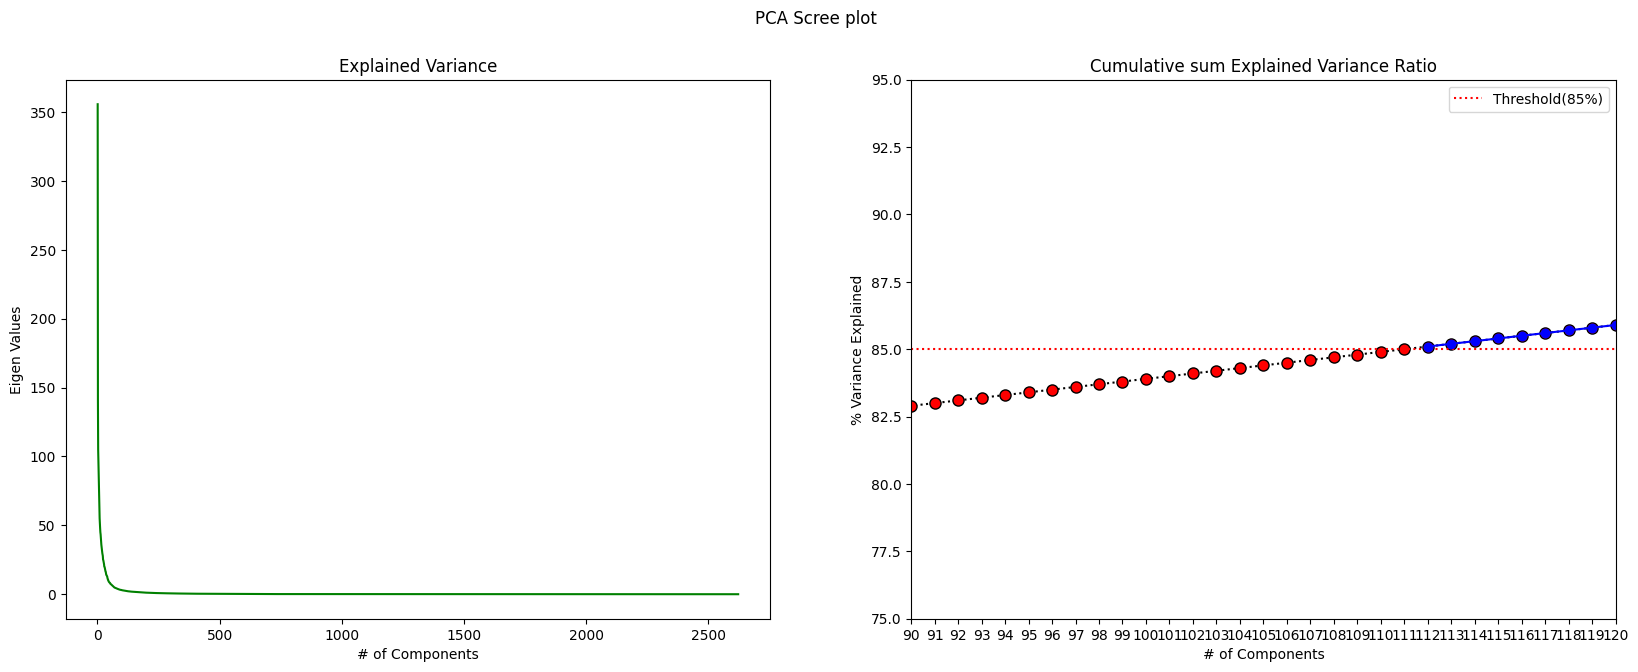

In [171]:
threshold=85
def generate_scree_plot(covar_matrix, threshold):
    var = covar_matrix.explained_variance_
    eigen_vals = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    f.suptitle('PCA Scree plot')
    ax1.plot(np.arange(1, len(var)+1), var, '-g')
    ax1.set_title('Explained Variance')
    ax1.set_xlabel('# of Components')
    ax1.set_ylabel('Eigen Values')

    ax2.plot(np.arange(1, len(eigen_vals)+1), eigen_vals, ':k', marker='o', markerfacecolor='red', markersize=8)
    ax2.set_xticks(np.arange(1, len(eigen_vals)+1))
    ax2.axhline(y=threshold, color='r', linestyle=':', label='Threshold(85%)')
    ax2.legend()
    ax2.plot(np.arange(sum(eigen_vals <= threshold) + 1, len(eigen_vals) + 1),
             [val for val in eigen_vals if val > threshold], '-bo')
    ax2.set_ylim(bottom=threshold-10, top=95)
    ax2.set_xlim([90,120])
    ax2.set_title('Cumulative sum Explained Variance Ratio')
    ax2.set_xlabel('# of Components')
    ax2.set_ylabel('% Variance Explained')


generate_scree_plot(covar_mat, threshold=threshold)

94 components explaining more than 85% of variance. Hence considering n_component as 94 for PCA

In [172]:
pca = PCA(n_components=94, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Build a Classifier
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [173]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
print('Score of the classifier: %.2f%%' % (clf.score(X_test, y_test) * 100))

Score of the classifier: 96.24%


### Test results
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

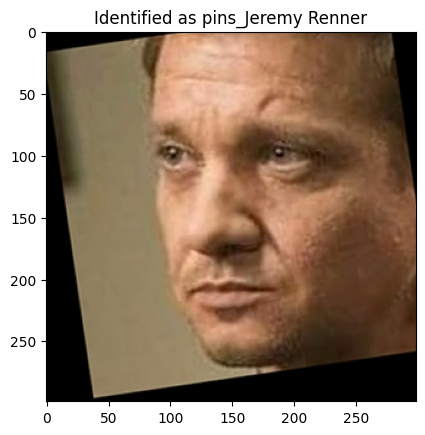

In [179]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = clf.predict([X_test[example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');